In [50]:
import torch 
import torchvision 
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import time

## Overview

- MNIST dataset 
    - hand drawn digits 
    - black and white images
    - NN's on this dataset are considered the "hello world" of NN
    - each image is a 28 X 28 pixel image = 784 pixels
    - each pixel corresponds to an input in the input layer
    - each pixel has a value of 0-255 traditionally, but is normalized to fit in between a value of 0-1
    - each image has a corresponding label that identifies which digit out of the 10 possible it represents
    
    
- Using Pytorch already cleaned MNIST dataset, have my neural networ try to learn to recognize hand written digits and classify them as accurately as possible.  

### Splitting data 

- Neural Net's learn from the data that is fed to them, they essentially try to minimize a cost function which is based on the outputs it's predicts and the actual values that are correct.

- So to make sure that our neural net is learning to be able to generalize across hand written digits instead of "overfitting" and simply learning the particular dataset it's being trained on. The data that we have must be split into two groups (can be 3, I believe, but 2 is neccessary). 
    - Training data, usually 70%-80% of the entire data set. This is the data that will be used to learn from
    - Testing data, seperate from the training data, this set will be used to evaluate how well our neural network is performing on "out of sample data" or data it hasn't seen yet. True indicator of ability of recognition.
   
### Data cleanliness

- This is very unrealistic of real world data, this data has been manipulated to be in a form that is perfect to use with PyTorch and can be used essentially immediately. Much of the work and time you put in will be making real world data usable, transform into a form that will allow to conduct learning from. But this is a good starting point.

- Another point to think about is the fact that if our data has e.g. 55% 3's and 5% for each of the other digits, the quickest way to decrease lost generally speaking is to guess 3 more of the time, which is a terrible thing for generlization but great to reduce cost based on the data set. Which is how the NN determines how to change the parameters of the model.
    - This is an issue of BALANCE

In [51]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))

test =  datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))


# BatchSize and Shuffle 

### BatchSize

- This particular dataset is not particularly large in terms of the memory on disk, however this is not always the case and in general when trying to learn new things, the larger our data set the better it is for our neural net to learn. So BatchSize is the size that we will use to determine Gradient Descent (GD). 
    - There is a trade off occuring here
        - Basically the batch will determine the way to change our weights and biases as to minimize our cost function.
        - Since it is only a small sample out of the entire data set, it is not guarenteed or even likely that the change will minimize the cost of the entire sample perfectl. However it will probably over many iterations give a pretty good direction to the minimum of the cost function, while not needing to process the entire data set. So the time gained from not needing to process the entire data set will pay for the fact we are not optimizing our change of weights to minimize the cost function.
        
        
        

### Shuffle 

- The MNIST data set could have each of the samples grouped based on the classification, e.g. all the 2's are together then 4's etc. As a result if our neural net is trained with the samples in this particular order. It will optimize at first to classify all digits as a 2 because that's all it has ever seen and known. Then when the 2's are exhausted and 4's show up it will have to radically change the weights, as it had no reason not to classify everything it saw as a 2. 

- Our goal is to have our Neural network be able to generally learn to recognize hand written digits. So we should try and help it as much as possible, because it is basically just trying to minimize a cost function and if that function is basically saying call everything a 2 it will do that. 

- Shuffle allows it to see a wider range of the data set, spread out better. Because the model doesn't know how good it can get and will not think ahead, instead it will simply try to decrease the cost as much as possible right now based on what it knows.

In [52]:
trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = True)
testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = True)

In [53]:
print(type(trainset))

"""
trainset is a DataLoader
data are 2 Tensors

First Tensor is all of the "raw data", the 2nd and last tensor are the labels corresponding to the data in the first tensor
"""


for data in trainset:
    print(data)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0

In [54]:
x,y = data[0][0], data[1][0]

print(y)

tensor(8)


In [55]:
print(data[0][0].shape)

torch.Size([1, 28, 28])


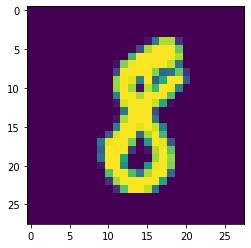

In [56]:
#above we see that data[0][0] has shape ([1,28,28]), which is a rank 3 tensor, so if we want to plto this and see how it 
#looks on matplotlib we have to change it's shape using view() to a "2d format"  

plt.imshow(data[0][0].view(28,28))
plt.show()

In [57]:
# verifying balance in data set

total = 0 
dict = {0:0, 
        1:0, 
        2:0,  
        3:0, 
        4:0, 
        5:0, 
        6:0, 
        7:0, 
        8:0, 
        9:0, 
       }


for data in trainset: 
    for d in data[1]:
        dict[int(d)] += 1
        total += 1

print(dict)
        

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [58]:
for i in dict:
    print("{}: percentage of {:.2f}%".format(i,dict[i]/total * 100))

0: percentage of 9.87%
1: percentage of 11.24%
2: percentage of 9.93%
3: percentage of 10.22%
4: percentage of 9.74%
5: percentage of 9.04%
6: percentage of 9.86%
7: percentage of 10.44%
8: percentage of 9.75%
9: percentage of 9.92%


In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Linear(input, output)
        #flatten the image into a column vector basically
        #first layer takes in the input which is the 28^2=784 pixels
        #the last layer which is fc4 must output 10 for the 10 possible digits
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
        
        # relu Rectified linear unit
        # activation function
        
        # softmax takes in the output vector and normalizes it to a probability distribution
        # limits the output to 0 - 1 range
        
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)
        

        
net = Net()
print(net)
        
        

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [60]:
X = torch.rand(28,28)

# the -1 indicates that it can be an array of any size? interesting 

X = X.view(-1,784)

In [61]:
output = net(X)
output

tensor([[-2.1557, -2.4043, -2.2592, -2.2558, -2.3653, -2.2763, -2.2992, -2.4266,
         -2.3782, -2.2382]], grad_fn=<LogSoftmaxBackward>)

In [75]:
# net.parameters talk about what is adjustable


optimizer = optim.Adam(net.parameters(), lr = 0.0001)

EPOCHS = 5
start = time.time()
for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of featuresets and labels
        X, y = data
        net.zero_grad() # batches hep to generali
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output,y)
        loss.backward()
        optimizer.step()
    print(loss)
end = time.time()
print("Time elapsed: {} sec".format(round(end - start, 3)));
        

tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(4.9776e-05, grad_fn=<NllLossBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor(3.5763e-08, grad_fn=<NllLossBackward>)
tensor(2.3842e-08, grad_fn=<NllLossBackward>)
Time elapsed: 103.073 sec


In [76]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1 
            total += 1

print("Accuracy: ", correct/total)

Accuracy:  0.9796


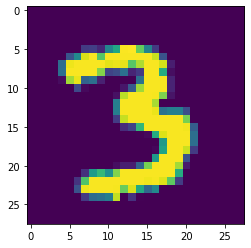

tensor(3)


PREDICTION


tensor(3, grad_fn=<NotImplemented>)


In [77]:
plt.imshow(X[0].view(28,28))
plt.show()

print(y[0])
print("\n")
print("PREDICTION")
print("\n")
print(torch.argmax(net(X[0].view(-1,784))[0]))


## Diff hyper params,

- Epoch = 5, LR = 0.0001
    - Accuracy: 0.9551
    - Time: 97.705 sec
    - loss over epoch
        - tensor(0.1222, grad_fn=<NllLossBackward>)
        - tensor(0.8047, grad_fn=<NllLossBackward>)
        - tensor(0.1421, grad_fn=<NllLossBackward>)
        - tensor(0.0839, grad_fn=<NllLossBackward>)
        - tensor(0.0054, grad_fn=<NllLossBackward>)

- Epoch = 5, LR = 0.0001
    - Accuracy: 0.9796
    - Time: 103.073
    - loss over epoch
        - tensor(0.0009, grad_fn=<NllLossBackward>)
        - tensor(4.9776e-05, grad_fn=<NllLossBackward>)
        - tensor(0., grad_fn=<NllLossBackward>)
        - tensor(3.5763e-08, grad_fn=<NllLossBackward>)
        - tensor(2.3842e-08, grad_fn=<NllLossBackward>)
  
- Epoch = 5, LR = 0.001
    - Accuracy: 0.9719
    - Time: 99.416 sec
    - loss over epoch
        - tensor(0.0303, grad_fn=<NllLossBackward>)
        - tensor(0.7818, grad_fn=<NllLossBackward>)
        - tensor(0.0120, grad_fn=<NllLossBackward>)
        - tensor(0.0207, grad_fn=<NllLossBackward>)
        - tensor(0.0039, grad_fn=<NllLossBackward>)

- Epoch = 3, LR = 0.001
    - Accuracy: 0.9742
    - Time: 59.715 sec
    - loss over epoch
        - tensor(0.0018, grad_fn=<NllLossBackward>)
        - tensor(0.0908, grad_fn=<NllLossBackward>)
        - tensor(0.0017, grad_fn=<NllLossBackward>)
    
- Epoch = 3, LR = 0.0001
    - Accuracy: 0.9789
    - Time: 58.7 sec
    - loss over epoch
        - tensor(2.5272e-06, grad_fn=<NllLossBackward>)
        - tensor(0.0005, grad_fn=<NllLossBackward>)
        - tensor(0.0015, grad_fn=<NllLossBackward>)
    

- Seems very luck based with multiple tries with the same params, sometimes the NN find's it's minimum extremely fast, sometimes it pops out of the minimum even with a low LR, in one of the epochs, just have to hope it isn't the last I suppose. the time gains are interesting. 
    
- Timing wise, O(E) makes sense this was done on CPU